In [10]:
import logging

logging.getLogger("tensorflow").setLevel(logging.ERROR)

In [11]:
import os
import pickle
import numpy as np
from tqdm.notebook import tqdm

from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add

In [12]:
BASE_DIR = '/kaggle/input/image-captioning-dataset-random-images'
WORKING_DIR = '/kaggle/working/'

In [13]:
# load vgg16 model
model = VGG16()
# restructure the model
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
# summarize
print(model.summary())

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [14]:
from PIL import UnidentifiedImageError

features = {}
directory = os.path.join(BASE_DIR, 'images')

for img_name in tqdm(os.listdir(directory)):
    try:
        # load the image from file
        img_path = os.path.join(directory, img_name)
        image = load_img(img_path, target_size=(224, 224))
        # convert image pixels to numpy array
        image = img_to_array(image)
        # reshape data for model
        image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
        # preprocess image for vgg
        image = preprocess_input(image)
        # extract features
        feature = model.predict(image, verbose=0)
        # get image ID
        image_id = img_name.split('.')[0]
        # store feature
        features[image_id] = feature
    except (UnidentifiedImageError, FileNotFoundError):
        # Skip the image if it cannot be identified or if the file is not found
        print(f"Skipped image: {img_name}")
        continue


  0%|          | 0/2047 [00:00<?, ?it/s]

Skipped image: image_captions.csv


In [15]:
len(features)

2046

In [18]:
pickle.dump(features, open(os.path.join(WORKING_DIR, 'features.pkl'), 'wb'))

In [19]:
with open(os.path.join(WORKING_DIR, 'features.pkl'), 'rb') as f:
    features = pickle.load(f)

In [20]:
import csv

mapping = {}
path_caption = '/kaggle/input/image-captioning-dataset-random-images/images'

with open(os.path.join(path_caption, 'image_captions.csv'), 'r') as f:
    reader = csv.reader(f)
    next(reader)

    for row in reader:
        img_id = row[0]
        captions = row[2].strip('[]').replace("'", "").split(',')

        if img_id not in mapping:
            mapping[img_id] = []

        mapping[img_id].append(captions)

In [21]:
len(mapping)

2046

In [22]:
import re

def clean(mapping):
    cleaned_mapping = {}
    for key, captions in mapping.items():
        cleaned_captions = []
        for caption in captions:
            # Check if the caption is a list
            if isinstance(caption, list):
                # If it's a list, join the elements into a single string
                caption = ' '.join(caption)
            # Convert to lowercase
            caption = caption.lower()
            # Remove digits, special characters, etc.
            caption = re.sub(r'[^a-zA-Z\s]', '', caption)
            # Remove additional spaces
            caption = re.sub(r'\s+', ' ', caption)
            # Remove single-character words
            caption = ' '.join([word for word in caption.split() if len(word) >= 2])
            # Add start and end tags to the caption (if required)
            # Example: caption = "<start> " + caption + " <end>"
            cleaned_captions.append(caption)
        cleaned_mapping[key] = cleaned_captions


In [23]:
clean(mapping)

In [24]:
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)
        

In [25]:
all_captions[:10]

[['Appetizer', ' Close-up', ' Snack', ' Food', ' Maasdam', ' Cheese'],
 ['Grape', ' Fruit', ' Boiled', ' Bun', ' Food', ' Cheese', ' Tea - ...'],
 ['Male',
  ' Teenager',
  ' Black Color',
  ' Ethnic',
  ' Child',
  ' Adult',
  ' African ...'],
 ['Drink',
  ' Breakfast',
  ' Food',
  ' Juice',
  ' Objects/Equipment',
  ' Fruit',
  ' Freshness',
  ' Morning',
  ' ...'],
 ['Onion',
  ' Picnic',
  ' Meat',
  ' Lunch',
  ' Kebab',
  ' Pork',
  ' Preparation',
  ' Refreshment',
  ' ...'],
 ['Bird', ' Snowy Owl', ' Carnivore', ' Animal', ' Animals And Pets', ' ...'],
 ['Toddler',
  ' Outdoors',
  ' Portrait',
  ' Male',
  ' 18-24 Months',
  ' Color Image',
  ' ...'],
 ['Portrait',
  ' Male Beauty',
  ' Men',
  ' Male',
  ' Bossy',
  ' Ordering',
  ' White ...'],
 ['Cathedral',
  ' Europe',
  ' Church',
  ' Orthodox',
  ' Jason Day - Actor',
  ' ...'],
 ['Wine',
  ' Liquid',
  ' Alcohol',
  ' Drink',
  ' Isolated On White',
  ' Close-up',
  ' ...']]

In [26]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

In [27]:
vocab_size

3744

In [28]:
max_length = max(len(str(caption).split(',')) for caption in all_captions)
max_length

9

In [29]:
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]

In [32]:
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    # loop over images
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            # process each caption
            for caption in captions:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # split the sequence into X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    
                    # store the sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield [X1, X2], y
                X1, X2, y = list(), list(), list()
                n = 0

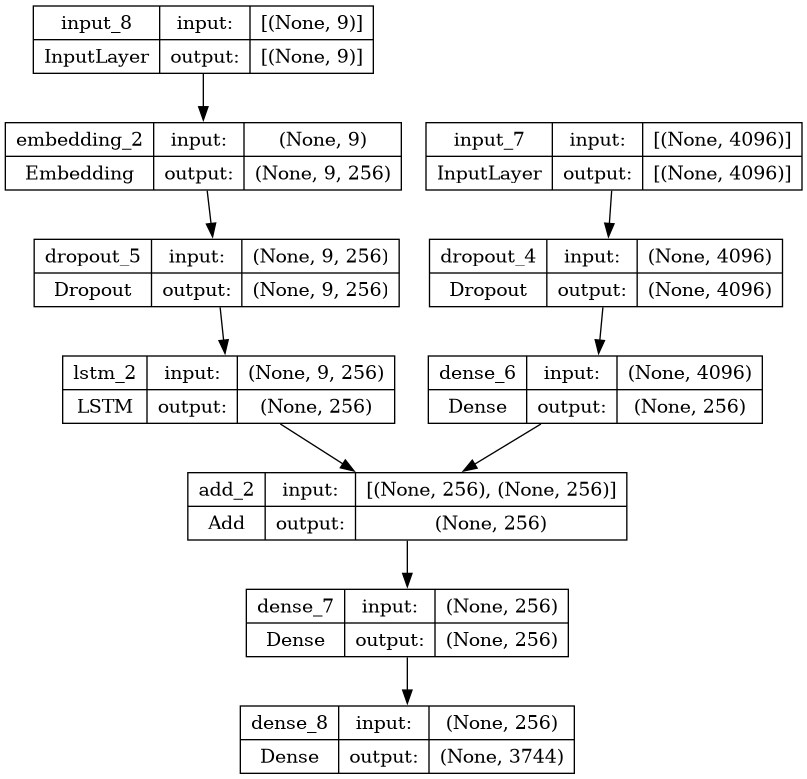

In [33]:
inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
# sequence feature layers
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

# decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

# plot the model
plot_model(model, show_shapes=True)

In [34]:
epochs = 20
batch_size = 32
steps = len(train) // batch_size

for i in range(epochs):
    # create data generator
    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    # fit for one epoch
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

57/57 [==============================] - 9s 157ms/step - loss: 1.7740


In [35]:
model.save(WORKING_DIR+'/best_model.h5')

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [36]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [37]:
def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = 'startseq'
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length)
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == 'endseq':
            break
      
    return in_text

In [41]:
# validate with test data
actual, predicted = list(), list()

for key in tqdm(test):
    # get actual captions
    captions = mapping[key]
    for caption in captions:
        # predict the caption for image
        y_pred = predict_caption(model, features[key], tokenizer, max_length) 
        # split predicted caption into words
        y_pred = y_pred.split()
        # append to the list
        actual.append([caption])
        predicted.append(y_pred)
    
# calculate BLEU score
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))


  0%|          | 0/205 [00:00<?, ?it/s]

BLEU-1: 0.000000
BLEU-2: 0.000000


In [44]:
from PIL import Image
import matplotlib.pyplot as plt
def generate_caption(image_name):
    # load the image
    # image_name = "1001773457_577c3a7d70.jpg"
    image_id = image_name.split('.')[0]
    img_path = os.path.join(BASE_DIR, "images", image_name)
    image = Image.open(img_path)
    captions = mapping[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)
    # predict the caption
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)

---------------------Actual---------------------
['Lily', ' Flower', ' Concepts And Ideas', ' Day', ' Time', ' Flowers', ' ...']
--------------------Predicted--------------------
startseq  day  day  day  day  day  day  day  day  day


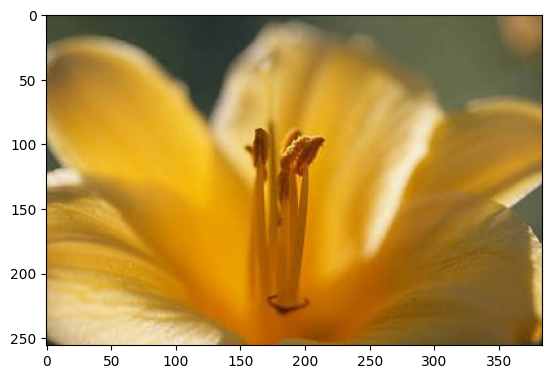

In [45]:
generate_caption("1002.jpg")

In [46]:
vgg_model = VGG16()
# restructure the model
vgg_model = Model(inputs=vgg_model.inputs, outputs=vgg_model.layers[-2].output)

In [47]:
image_path = '/kaggle/input/image-captioning-dataset-random-images/images/0.jpg'
# load image
image = load_img(image_path, target_size=(224, 224))
# convert image pixels to numpy array
image = img_to_array(image)
# reshape data for model
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
# preprocess image for vgg
image = preprocess_input(image)
# extract features
feature = vgg_model.predict(image, verbose=0)
# predict from the trained model
predict_caption(model, feature, tokenizer, max_length)

'startseq  maasdam  maasdam  maasdam  maasdam  maasdam  maasdam  maasdam  maasdam  maasdam'